In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [4]:
# Define data augmentation and normalization transforms
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, scale=(0.9, 1.1)),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

# Load CIFAR-100 dataset
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

# Get class names and mappings
classes = train_dataset.classes
class_to_idx = train_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Define animal classes
animal_classes = [1, 3, 4, 15, 21, 27, 30, 31, 34, 38, 42, 43, 44, 50, 72, 73, 78, 88, 93, 97]

# Create label mappings
label_to_new_label = {label: idx for idx, label in enumerate(animal_classes)}
new_label_to_class_name = {idx: idx_to_class[label] for label, idx in label_to_new_label.items()}

# Get indices of animal class samples
train_labels = train_dataset.targets
test_labels = test_dataset.targets

animal_train_indices = [i for i, label in enumerate(train_labels) if label in animal_classes]
animal_test_indices = [i for i, label in enumerate(test_labels) if label in animal_classes]

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Create custom dataset for animals
class AnimalCIFAR100Dataset(Dataset):
    def __init__(self, subset, label_map):
        self.subset = subset
        self.label_map = label_map

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        img, label = self.subset[idx]
        new_label = self.label_map[label]
        return img, new_label

# Create animal datasets
train_dataset_animals = AnimalCIFAR100Dataset(Subset(train_dataset, animal_train_indices), label_to_new_label)
test_dataset_animals = AnimalCIFAR100Dataset(Subset(test_dataset, animal_test_indices), label_to_new_label)

# Create data loaders
train_loader = DataLoader(train_dataset_animals, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset_animals, batch_size=64, shuffle=False)

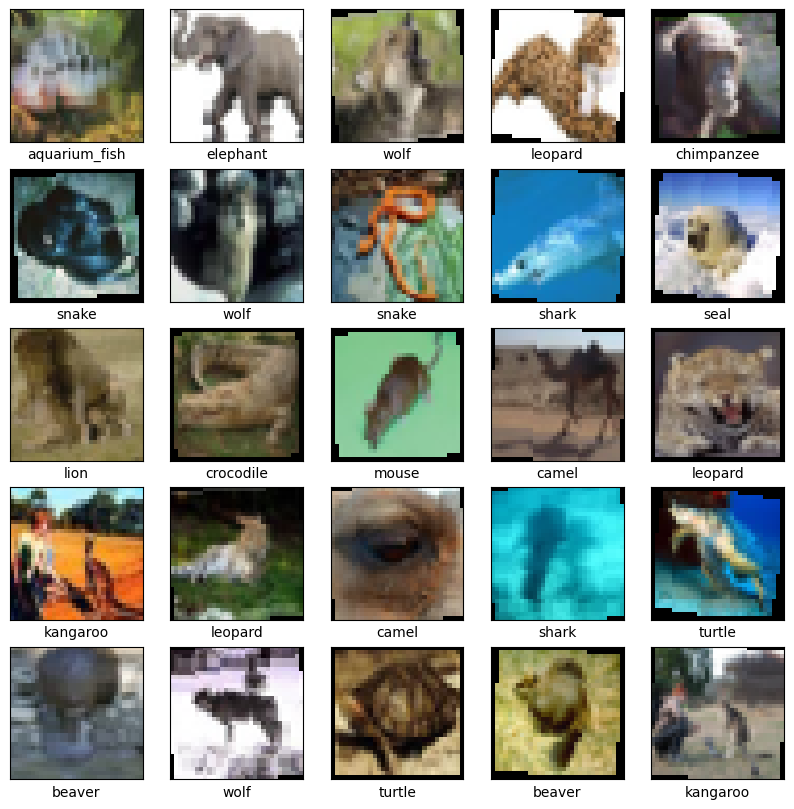

In [6]:
# Visualize some images
images, labels = zip(*[train_dataset_animals[i] for i in range(25)])
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = images[i].numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.xlabel(new_label_to_class_name[labels[i]])
plt.show()

In [7]:
# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self, num_classes=20):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)  # Output size: (16, 16)
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # Output size: (8, 8)
        x = F.relu(self.conv3(x))
        x = self.pool(x)  # Output size: (4, 4)
        x = self.dropout(x)
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
# Initialize the model, loss function, and optimizer
model = CNNModel(num_classes=len(animal_classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Device configuration
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using MPS backend")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA backend")
else:
    device = torch.device('cpu')
    print("Using CPU")
model.to(device)


Using MPS backend


CNNModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=20, bias=True)
)

In [11]:
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item() * inputs.size(0)

    # Calculate average loss over an epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')

Epoch 1/100, Loss: 2.7484
Epoch 2/100, Loss: 2.4720
Epoch 3/100, Loss: 2.3815
Epoch 4/100, Loss: 2.3092
Epoch 5/100, Loss: 2.2500
Epoch 6/100, Loss: 2.1911
Epoch 7/100, Loss: 2.1508
Epoch 8/100, Loss: 2.0920
Epoch 9/100, Loss: 2.0391
Epoch 10/100, Loss: 1.9871
Epoch 11/100, Loss: 1.9571
Epoch 12/100, Loss: 1.9192
Epoch 13/100, Loss: 1.8857
Epoch 14/100, Loss: 1.8348
Epoch 15/100, Loss: 1.8088
Epoch 16/100, Loss: 1.7902
Epoch 17/100, Loss: 1.7675
Epoch 18/100, Loss: 1.7319
Epoch 19/100, Loss: 1.7176
Epoch 20/100, Loss: 1.6857
Epoch 21/100, Loss: 1.6766
Epoch 22/100, Loss: 1.6625
Epoch 23/100, Loss: 1.6132
Epoch 24/100, Loss: 1.6131
Epoch 25/100, Loss: 1.5622
Epoch 26/100, Loss: 1.5616
Epoch 27/100, Loss: 1.5454
Epoch 28/100, Loss: 1.5333
Epoch 29/100, Loss: 1.5245
Epoch 30/100, Loss: 1.5056
Epoch 31/100, Loss: 1.4752
Epoch 32/100, Loss: 1.4650
Epoch 33/100, Loss: 1.4618
Epoch 34/100, Loss: 1.4539
Epoch 35/100, Loss: 1.4230
Epoch 36/100, Loss: 1.4037
Epoch 37/100, Loss: 1.3914
Epoch 38/1

In [12]:
# Evaluate the model on test data
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.4955
